<a href="https://colab.research.google.com/github/M-SHINY/AIML_PROJECT-PLANT-DISEASE-DETECTION-/blob/main/FINAL_AIML_PROJECTipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow keras opencv-python-headless matplotlib seaborn scikit-learn
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


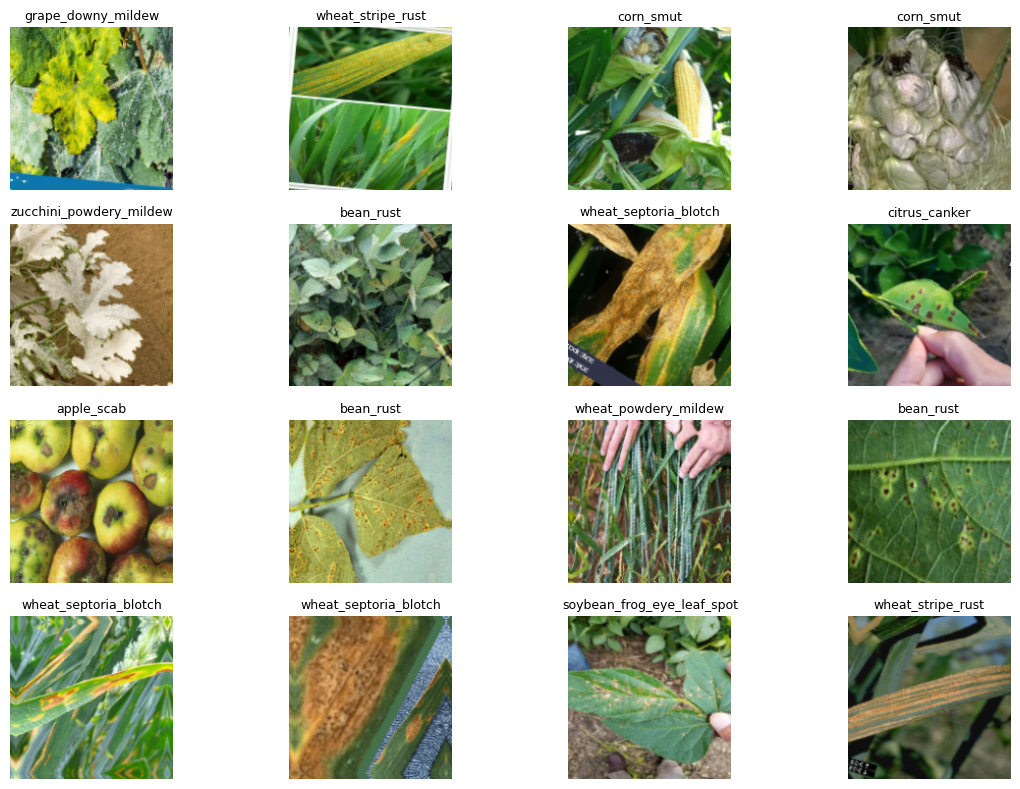

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# show one batch from train_ds (already defined)
for imgs, labs in train_ds.take(1):
    imgs = imgs.numpy()
    labs = labs.numpy()
    break

inv = {v:k for k,v in class_to_idx.items()}
plt.figure(figsize=(12,8))
for i in range(min(16, imgs.shape[0])):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(imgs[i])
    plt.title(inv[int(labs[i])], fontsize=9)
    plt.axis('off')
plt.tight_layout()


In [ ]:
import json
model.save(str(ckpt_dir / "plant_disease_final_model.keras"))

with open(ckpt_dir / "class_mapping.json", "w") as f:
    json.dump(class_to_idx, f)
print("✅ Model and label mapping saved!")


✅ Model and label mapping saved!


🚀 Step 1: Setting up Data (128x128)...
✅ Selected Classes: ['citrus_canker', 'grape_downy_mildew', 'apple_scab', 'corn_smut', 'cucumber_powdery_mildew', 'tomato_early_blight', 'peach_leaf_curl', 'squash_powdery_mildew', 'cucumber_angular_leaf_spot', 'corn_rust', 'soybean_frog_eye_leaf_spot_Bing', 'tomato_late_blight']
Copying images locally...
✅ Copied 2556 images.
🧠 Building MobileNetV2 (Feature Extraction Only)...
2019640/2019640 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
⏳ Training (15 epochs)...
Epoch 1/15
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.1604 - loss: 2.5938
Epoch 1: val_loss improved from inf to 1.46305, saving model to /content/drive/MyDrive/AIML_Project/plantsegv2/models/plant_disease_final_model.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 197ms/step - accuracy: 0.1655 - loss: 2.5765 - val_accuracy: 0.5403 - val_loss: 1.4630
Epoch 2/15
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.5333 - loss: 1.3514
Epoch 2: val_loss improved from 1.46305 to 1.23110, saving model t

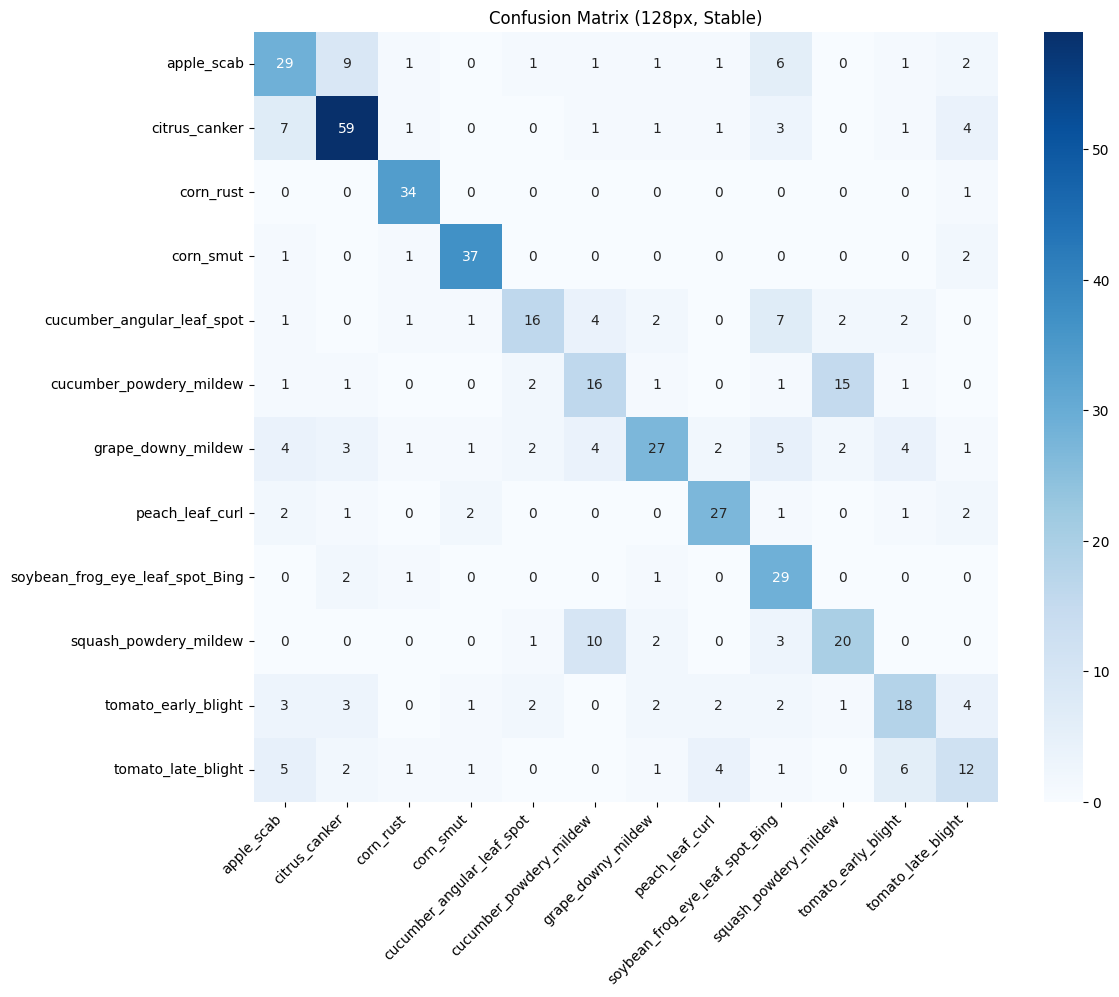

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
import shutil
import os
import json
import time
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ================= CONFIGURATION =================
# Increased size slightly for better detail, kept batch size for speed
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 15             # Train longer since we aren't fine-tuning
USE_TOP_K = 12

# Paths
DRIVE_PATH = Path("/content/drive/MyDrive/AIML_Project/plantsegv2/images")
LOCAL_DIR = Path("/content/temp_data_cpu_v3")
MODELS_DIR = Path("/content/drive/MyDrive/AIML_Project/plantsegv2/models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print("🚀 Step 1: Setting up Data (128x128)...")

# 1. CLEAN & PREPARE LOCAL FOLDER
if LOCAL_DIR.exists(): shutil.rmtree(LOCAL_DIR)
LOCAL_DIR.mkdir()

# 2. SCAN DRIVE
all_files = []
all_labels = []

for split in ["train", "val", "test"]:
    d = DRIVE_PATH / split
    if d.exists():
        for f in d.iterdir():
            if f.suffix.lower() in [".jpg", ".png", ".jpeg"]:
                name = f.stem
                parts = name.split("_")
                while parts and (parts[-1].isdigit() or parts[-1] in ['google','bing','baidu']):
                    parts.pop()
                if parts:
                    label = "_".join(parts)
                    all_files.append(f)
                    all_labels.append(label)

# Filter Top 12
counts = Counter(all_labels)
top_classes = [c for c, _ in counts.most_common(USE_TOP_K)]
print(f"✅ Selected Classes: {top_classes}")

# 3. COPY FILES
local_paths = []
final_labels = []

print("Copying images locally...")
for src, label in zip(all_files, all_labels):
    if label in top_classes:
        dst = LOCAL_DIR / src.name
        shutil.copy(src, dst)
        local_paths.append(str(dst))
        final_labels.append(label)

print(f"✅ Copied {len(local_paths)} images.")

# 4. PREPARE DATASETS
class_names = sorted(top_classes)
class_to_idx = {c: i for i, c in enumerate(class_names)}
y_indices = [class_to_idx[l] for l in final_labels]

# Save Mapping
with open(MODELS_DIR / "class_mapping.json", "w") as f:
    json.dump(class_to_idx, f)

# Split
X_train, X_test, y_train, y_test = train_test_split(local_paths, y_indices, test_size=0.2, stratify=y_indices, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# Augmentation (Gentle)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

def get_ds(paths, labels, train=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    def load(p, y):
        img = tf.io.read_file(p)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.cast(img, tf.float32)
        img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
        return img, y

    autotune = tf.data.AUTOTUNE
    ds = ds.map(load, num_parallel_calls=autotune)

    if train:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=autotune)
        ds = ds.shuffle(len(paths))

    return ds.batch(BATCH_SIZE).prefetch(autotune)

train_ds = get_ds(X_train, y_train, train=True)
val_ds = get_ds(X_val, y_val)
test_ds = get_ds(X_test, y_test)

# 5. BUILD MODEL (NO FINE TUNING)
print("🧠 Building MobileNetV2 (Feature Extraction Only)...")
base = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    alpha=0.35, include_top=False, weights='imagenet'
)
base.trainable = False  # Keep frozen!

inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x) # Lower dropout for stability
outputs = layers.Dense(len(class_names), activation='softmax')(x)
model = models.Model(inputs, outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 6. TRAIN
ckpt_path = str(MODELS_DIR / "plant_disease_final_model.keras")
cb = [
    callbacks.ModelCheckpoint(ckpt_path, save_best_only=True, monitor='val_loss', verbose=1),
    callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

print(f"⏳ Training ({EPOCHS} epochs)...")
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=cb, verbose=1)

# 7. EVALUATE
print("📊 Final Evaluation...")
model.load_weights(ckpt_path)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true_test = []
for _, lbls in test_ds:
    y_true_test.extend(lbls.numpy())

print(classification_report(y_true_test, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (128px, Stable)")
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading model...
✅ Model loaded! It knows 13 classes (including 'Other').
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


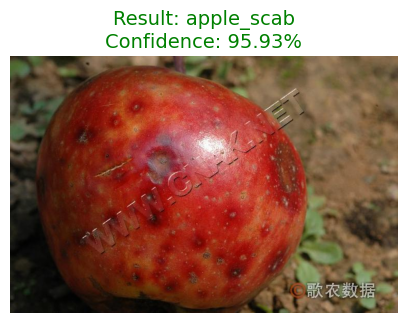

🌿 DIAGNOSIS: apple_scab


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path

# 1. SETUP PATHS
# Make sure these point to your NEW 13-class model
ckpt_dir = Path("/content/drive/MyDrive/AIML_Project/plantsegv2/models")
model_path = ckpt_dir / "plant_disease_final_model.keras"
labels_path = ckpt_dir / "class_mapping.json"

# 2. LOAD MODEL
print("Loading model...")
model = tf.keras.models.load_model(model_path)

with open(labels_path) as f:
    class_to_idx = json.load(f)
idx_to_class = {v: k for k, v in class_to_idx.items()}
print(f"✅ Model loaded! It knows {len(idx_to_class)} classes (including 'Other').")

# 3. PREDICT FUNCTION
def predict_with_other(img_path):
    if not Path(img_path).exists():
        print(f"❌ Error: File not found at {img_path}")
        return

    # Load Image (MUST BE 128x128 to match your latest training)
    img = image.load_img(img_path, target_size=(128, 128))

    # Preprocess
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    # Predict
    predictions = model.predict(img_array)
    pred_index = np.argmax(predictions)
    confidence = np.max(predictions) * 100
    result_label = idx_to_class[pred_index]

    # Show
    plt.figure(figsize=(5,5))
    plt.imshow(image.load_img(img_path))
    plt.axis('off')

    # Color logic: Green if it's a specific disease, Grey if it's "Other"
    text_color = 'gray' if result_label == "Other" else 'green'

    plt.title(f"Result: {result_label}\nConfidence: {confidence:.2f}%", color=text_color, fontsize=14)
    plt.show()

    print(f"🌿 DIAGNOSIS: {result_label}")

# ==========================================
# 👇 PASTE THE PATH TO "APPLE BLACK ROT" HERE 👇
# ==========================================
test_image = "/content/drive/MyDrive/AIML_Project/test_images/apple_scab_2.jpg"

predict_with_other(test_image)

Loading model...
✅ Model loaded! It knows 13 classes (including 'Other').
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


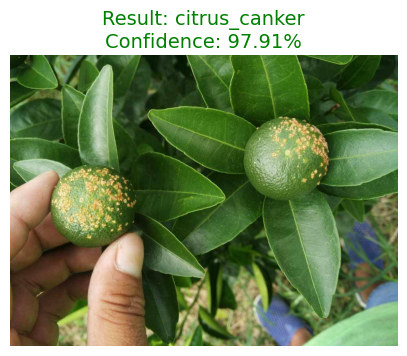

🌿 DIAGNOSIS: citrus_canker


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path

# 1. SETUP PATHS
# Make sure these point to your NEW 13-class model
ckpt_dir = Path("/content/drive/MyDrive/AIML_Project/plantsegv2/models")
model_path = ckpt_dir / "plant_disease_final_model.keras"
labels_path = ckpt_dir / "class_mapping.json"

# 2. LOAD MODEL
print("Loading model...")
model = tf.keras.models.load_model(model_path)

with open(labels_path) as f:
    class_to_idx = json.load(f)
idx_to_class = {v: k for k, v in class_to_idx.items()}
print(f"✅ Model loaded! It knows {len(idx_to_class)} classes (including 'Other').")

# 3. PREDICT FUNCTION
def predict_with_other(img_path):
    if not Path(img_path).exists():
        print(f"❌ Error: File not found at {img_path}")
        return

    # Load Image (MUST BE 128x128 to match your latest training)
    img = image.load_img(img_path, target_size=(128, 128))

    # Preprocess
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    # Predict
    predictions = model.predict(img_array)
    pred_index = np.argmax(predictions)
    confidence = np.max(predictions) * 100
    result_label = idx_to_class[pred_index]

    # Show
    plt.figure(figsize=(5,5))
    plt.imshow(image.load_img(img_path))
    plt.axis('off')

    # Color logic: Green if it's a specific disease, Grey if it's "Other"
    text_color = 'gray' if result_label == "Other" else 'green'

    plt.title(f"Result: {result_label}\nConfidence: {confidence:.2f}%", color=text_color, fontsize=14)
    plt.show()

    print(f"🌿 DIAGNOSIS: {result_label}")

# ==========================================
# 👇 PASTE THE PATH TO "APPLE BLACK ROT" HERE 👇
# ==========================================
test_image = "/content/drive/MyDrive/AIML_Project/test_images/citrus_canker_38.jpg"

predict_with_other(test_image)

Loading model...
✅ Model loaded! It knows 13 classes (including 'Other').
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


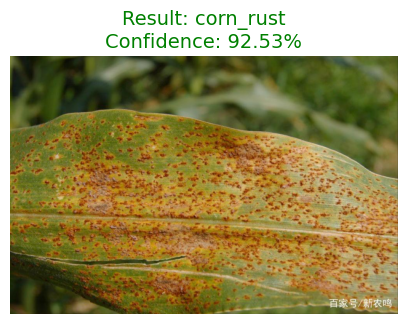

🌿 DIAGNOSIS: corn_rust


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path

# 1. SETUP PATHS
# Make sure these point to your NEW 13-class model
ckpt_dir = Path("/content/drive/MyDrive/AIML_Project/plantsegv2/models")
model_path = ckpt_dir / "plant_disease_final_model.keras"
labels_path = ckpt_dir / "class_mapping.json"

# 2. LOAD MODEL
print("Loading model...")
model = tf.keras.models.load_model(model_path)

with open(labels_path) as f:
    class_to_idx = json.load(f)
idx_to_class = {v: k for k, v in class_to_idx.items()}
print(f"✅ Model loaded! It knows {len(idx_to_class)} classes (including 'Other').")

# 3. PREDICT FUNCTION
def predict_with_other(img_path):
    if not Path(img_path).exists():
        print(f"❌ Error: File not found at {img_path}")
        return

    # Load Image (MUST BE 128x128 to match your latest training)
    img = image.load_img(img_path, target_size=(128, 128))

    # Preprocess
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    # Predict
    predictions = model.predict(img_array)
    pred_index = np.argmax(predictions)
    confidence = np.max(predictions) * 100
    result_label = idx_to_class[pred_index]

    # Show
    plt.figure(figsize=(5,5))
    plt.imshow(image.load_img(img_path))
    plt.axis('off')

    # Color logic: Green if it's a specific disease, Grey if it's "Other"
    text_color = 'gray' if result_label == "Other" else 'green'

    plt.title(f"Result: {result_label}\nConfidence: {confidence:.2f}%", color=text_color, fontsize=14)
    plt.show()

    print(f"🌿 DIAGNOSIS: {result_label}")

# ==========================================
# 👇 PASTE THE PATH TO "APPLE BLACK ROT" HERE 👇
# ==========================================
test_image = "/content/drive/MyDrive/AIML_Project/test_images/corn_rust_17.jpg"

predict_with_other(test_image)

Loading model...
✅ Model loaded! It knows 13 classes (including 'Other').


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


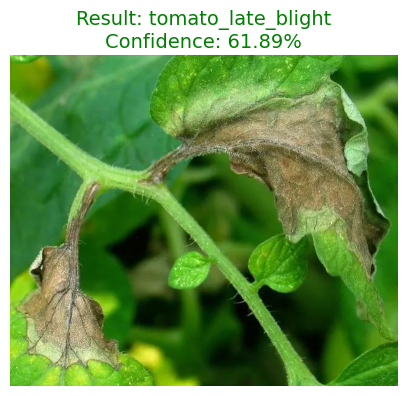

🌿 DIAGNOSIS: tomato_late_blight


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path

# 1. SETUP PATHS
# Make sure these point to your NEW 13-class model
ckpt_dir = Path("/content/drive/MyDrive/AIML_Project/plantsegv2/models")
model_path = ckpt_dir / "plant_disease_final_model.keras"
labels_path = ckpt_dir / "class_mapping.json"

# 2. LOAD MODEL
print("Loading model...")
model = tf.keras.models.load_model(model_path)

with open(labels_path) as f:
    class_to_idx = json.load(f)
idx_to_class = {v: k for k, v in class_to_idx.items()}
print(f"✅ Model loaded! It knows {len(idx_to_class)} classes (including 'Other').")

# 3. PREDICT FUNCTION
def predict_with_other(img_path):
    if not Path(img_path).exists():
        print(f"❌ Error: File not found at {img_path}")
        return

    # Load Image (MUST BE 128x128 to match your latest training)
    img = image.load_img(img_path, target_size=(128, 128))

    # Preprocess
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    # Predict
    predictions = model.predict(img_array)
    pred_index = np.argmax(predictions)
    confidence = np.max(predictions) * 100
    result_label = idx_to_class[pred_index]

    # Show
    plt.figure(figsize=(5,5))
    plt.imshow(image.load_img(img_path))
    plt.axis('off')

    # Color logic: Green if it's a specific disease, Grey if it's "Other"
    text_color = 'gray' if result_label == "Other" else 'green'

    plt.title(f"Result: {result_label}\nConfidence: {confidence:.2f}%", color=text_color, fontsize=14)
    plt.show()

    print(f"🌿 DIAGNOSIS: {result_label}")

# ==========================================
# 👇 PASTE THE PATH TO "APPLE BLACK ROT" HERE 👇
# ==========================================
test_image = "/content/drive/MyDrive/AIML_Project/test_images/tomato_late_blight_24.jpg"

predict_with_other(test_image)